In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import aplpy

import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/process_tools")
from cut_resize_tools import *
from Astronomy import *

In [2]:
fits_path = "/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"
integ_hdu = fits.open("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/processed_fits/CygnusX_sp16_120-230_integrate_map.fits")[0]

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]
wcs = WCS(integ_hdu.header)

raw_d = hdu.data
header = hdu.header

In [3]:
vsmooth = 5
thresh = 1
sigma = 2
sch_rms = 10
ech_rms = 90
sch_ii = 1
ech_ii = 320
percentile = 99.997
sigma_multiply = None
# width = 60

cut_size_list = [256, 128, 64]
integrate_layer_num = 30
obj_size = 100
maximum_mode = "percentile"

In [4]:
catalogue_path = '/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/cygnus_infer_catalogue.csv' # 提供されたCSVファイル
catalogue_data = pd.read_csv(catalogue_path)

# バブルデータ作成

In [5]:
babble_region_galactic = [] # 変換後の銀河座標を格納するリスト
for index, row in catalogue_data.iterrows():
    RA_min = row['ra_min'] * u.deg # 度単位でUnitsオブジェクトを作成
    RA_max = row['ra_max'] * u.deg
    DEC_min = row['dec_min'] * u.deg
    DEC_max = row['dec_max'] * u.deg

    # 各角の赤経・赤緯座標をSkyCoordオブジェクトとして定義
    # そして銀河座標系に変換
    # RA_min, DEC_min の点
    coord_min_min = SkyCoord(ra=RA_min, dec=DEC_min, frame='icrs').galactic
    # RA_max, DEC_min の点
    coord_max_min = SkyCoord(ra=RA_max, dec=DEC_min, frame='icrs').galactic
    # RA_min, DEC_max の点
    coord_min_max = SkyCoord(ra=RA_min, dec=DEC_max, frame='icrs').galactic
    # RA_max, DEC_max の点
    coord_max_max = SkyCoord(ra=RA_max, dec=DEC_max, frame='icrs').galactic

    # 変換された銀河座標 (l, b) のリストを作成
    babble_region_galactic.append([
        [coord_min_min.l.deg, coord_min_min.b.deg], # 0: L_min, B_min
        [coord_max_min.l.deg, coord_max_min.b.deg], # 1: L_max, B_min
        [coord_min_max.l.deg, coord_min_max.b.deg], # 2: L_min, B_max
        [coord_max_max.l.deg, coord_max_max.b.deg]  # 3: L_max, B_max
    ])
print(f"babble_region_galactic len: {len(babble_region_galactic)}")


# --- babble_region_pix への変換 (修正) ---
# ループ元を babble_region_galactic に変更
babble_region_pix = []
for i in range(len(babble_region_galactic)):
    babble_region = babble_region_galactic[i] # 銀河座標のバブル領域
    region_list = []
    for j in range(len(babble_region)):
        world_coords_list = [list(babble_region[j])] # [L, B] のリスト
        
        # WCS変換。世界座標 (L, B) をピクセル座標に変換
        # origin=0 でPythonの0-based indexに対応
        region_pix_result = wcs.wcs_world2pix(world_coords_list, 0)

        # 変換結果の形状と要素数をチェックする
        if len(region_pix_result) > 0 and len(region_pix_result[0]) == 2:
            region_list.append(region_pix_result[0]) # 期待通り [x, y] を追加
        else:
            print(f"警告: bubble_num={i}, point_idx={j} のWCS変換結果が不正です: {region_pix_result}. NaNで埋めます。")
            region_list.append([np.nan, np.nan]) # NaNで埋めて、後で除外されるようにする

    babble_region_pix.append(region_list)
print(f"babble_region_pix len: {len(babble_region_pix)}")

babble_region_galactic len: 78
babble_region_pix len: 78


In [6]:
val_x_min, val_x_max, val_y_min, val_y_max = 1350, 2150, 800, 1300
test_y_min, test_y_max, test_x_min, test_x_max = 1020, 1500, 700, 1350

In [7]:
cutting_ratio = 2
training_region_data_dic = {}
validation_region_data_dic = {}
test_region_data_dic = {}
data_to_cut = raw_d.copy() # raw_d からのコピー

for bubble_num in range(len(babble_region_pix)):
    all_x_coords = [p[0] for p in babble_region_pix[bubble_num]]
    all_y_coords = [p[1] for p in babble_region_pix[bubble_num]]

    # ピクセル座標の最小値と最大値を取得
    # np.min と np.max を使うことで、座標の順序に関わらず正しい矩形領域の境界を取得
    # これにより、x_max_pix < x_min_pix のような逆転を防ぎ、スライス範囲が巨大になるのを防ぐ
    x_min_pix = int(np.floor(np.min(all_x_coords)))
    x_max_pix = int(np.ceil(np.max(all_x_coords)))
    y_min_pix = int(np.floor(np.min(all_y_coords)))
    y_max_pix = int(np.ceil(np.max(all_y_coords)))

    x_center = (x_min_pix + x_max_pix) // 2 
    y_center = (y_min_pix + y_max_pix) // 2

    x_range = (x_max_pix - x_min_pix) // 2 * cutting_ratio
    y_range = (y_max_pix - y_min_pix) // 2 * cutting_ratio

    x_min_pix = int(x_center - x_range)
    x_max_pix = int(x_center + x_range)
    y_min_pix = int(y_center - y_range)
    y_max_pix = int(y_center + y_range)

    if y_min_pix > val_y_min and y_max_pix < val_y_max and x_min_pix > val_x_min and x_max_pix < val_x_max:
        data_dic = validation_region_data_dic
    
    elif y_min_pix > test_y_min and y_max_pix < test_y_max and x_min_pix > test_x_min and x_max_pix < test_x_max:
        data_dic = test_region_data_dic
        
    else:
        data_dic = training_region_data_dic

    # 切り出し実行
    cutting_data = data_to_cut[:, y_min_pix:y_max_pix, x_min_pix:x_max_pix]
    pix_cood = (x_min_pix, x_max_pix, y_min_pix, y_max_pix)
    data_dic[pix_cood] = cutting_data

    # デバッグ用に切り出したデータの形状と範囲を表示してみる
    # print(f"Bubble {bubble_num}: X range [{x_min_pix}, {x_max_pix}], Y range [{y_min_pix}, {y_max_pix}], Shape: {cutting_data.shape}")

In [8]:
print(len(validation_region_data_dic))
print(len(test_region_data_dic))
print(len(training_region_data_dic))

10
5
63


In [9]:
deleted_indices = []
validation_region_list = [
    data for idx, data in enumerate(validation_region_data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(validation_region_list))

削除されたデータのインデックス: [7]
削除された数:  1
残ったデータ数:  9


In [10]:
deleted_indices = []
test_region_list = [
    data for idx, data in enumerate(test_region_data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(test_region_list))

削除されたデータのインデックス: []
削除された数:  0
残ったデータ数:  5


In [11]:
deleted_indices = []
training_region_list = [
    data for idx, data in enumerate(training_region_data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(training_region_list))

削除されたデータのインデックス: [2, 4, 6, 8, 9, 10, 15, 17, 19, 20, 21, 23, 25, 26, 28, 29, 30, 31, 33, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 54, 56, 58]
削除された数:  36
残ったデータ数:  27


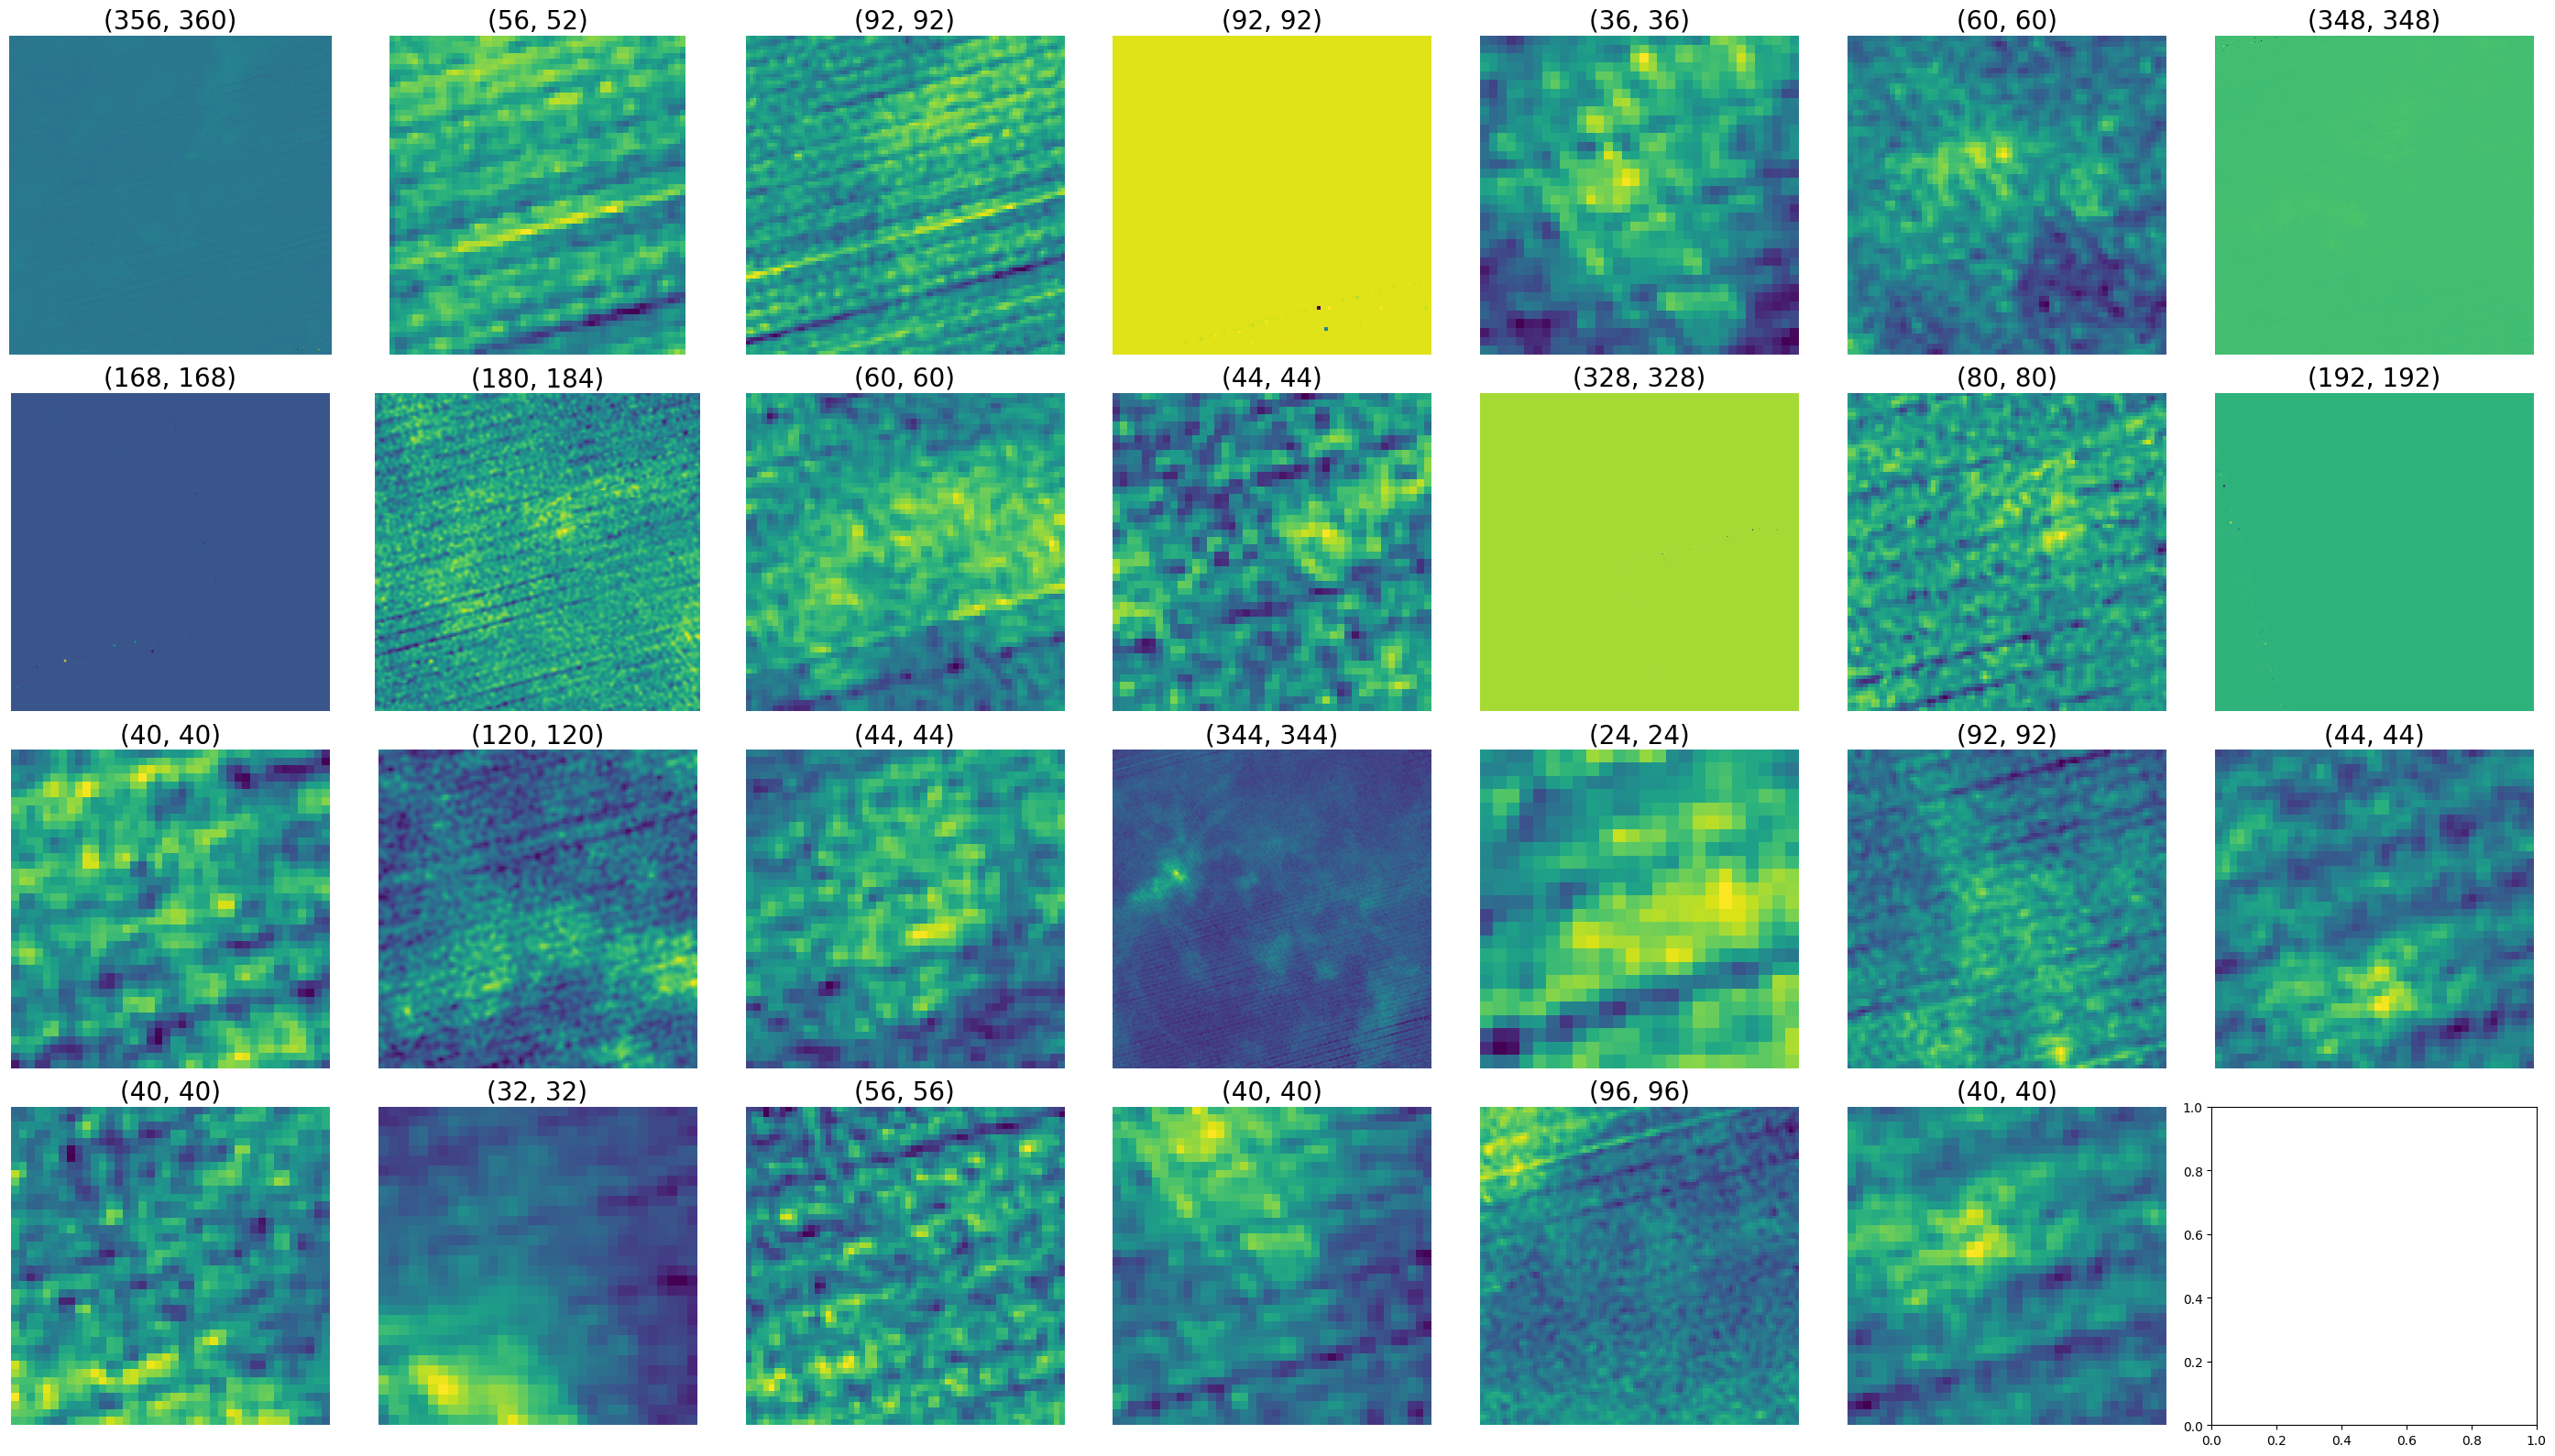

In [12]:
# Training Data 確認

rows = len(training_region_list) // 7 + 1

fig, axes = plt.subplots(rows, 7, figsize=(4*7, 4*rows))
axes = axes.flatten()  # 3x10の軸を1次元配列に変換

for n in range(len(training_region_list)):  # 30個の画像を配置
    data = training_region_list[n][1]
    integ_data = np.nansum(data, axis=0)
    
    axes[n].imshow(integ_data)
    axes[n].axis("off")
    axes[n].set_title((training_region_list[n][1].shape[1], training_region_list[n][1].shape[2]), fontsize=20)

plt.tight_layout()
# plt.savefig("bubbles_zeroing_integ_shape_3.png")
plt.show()

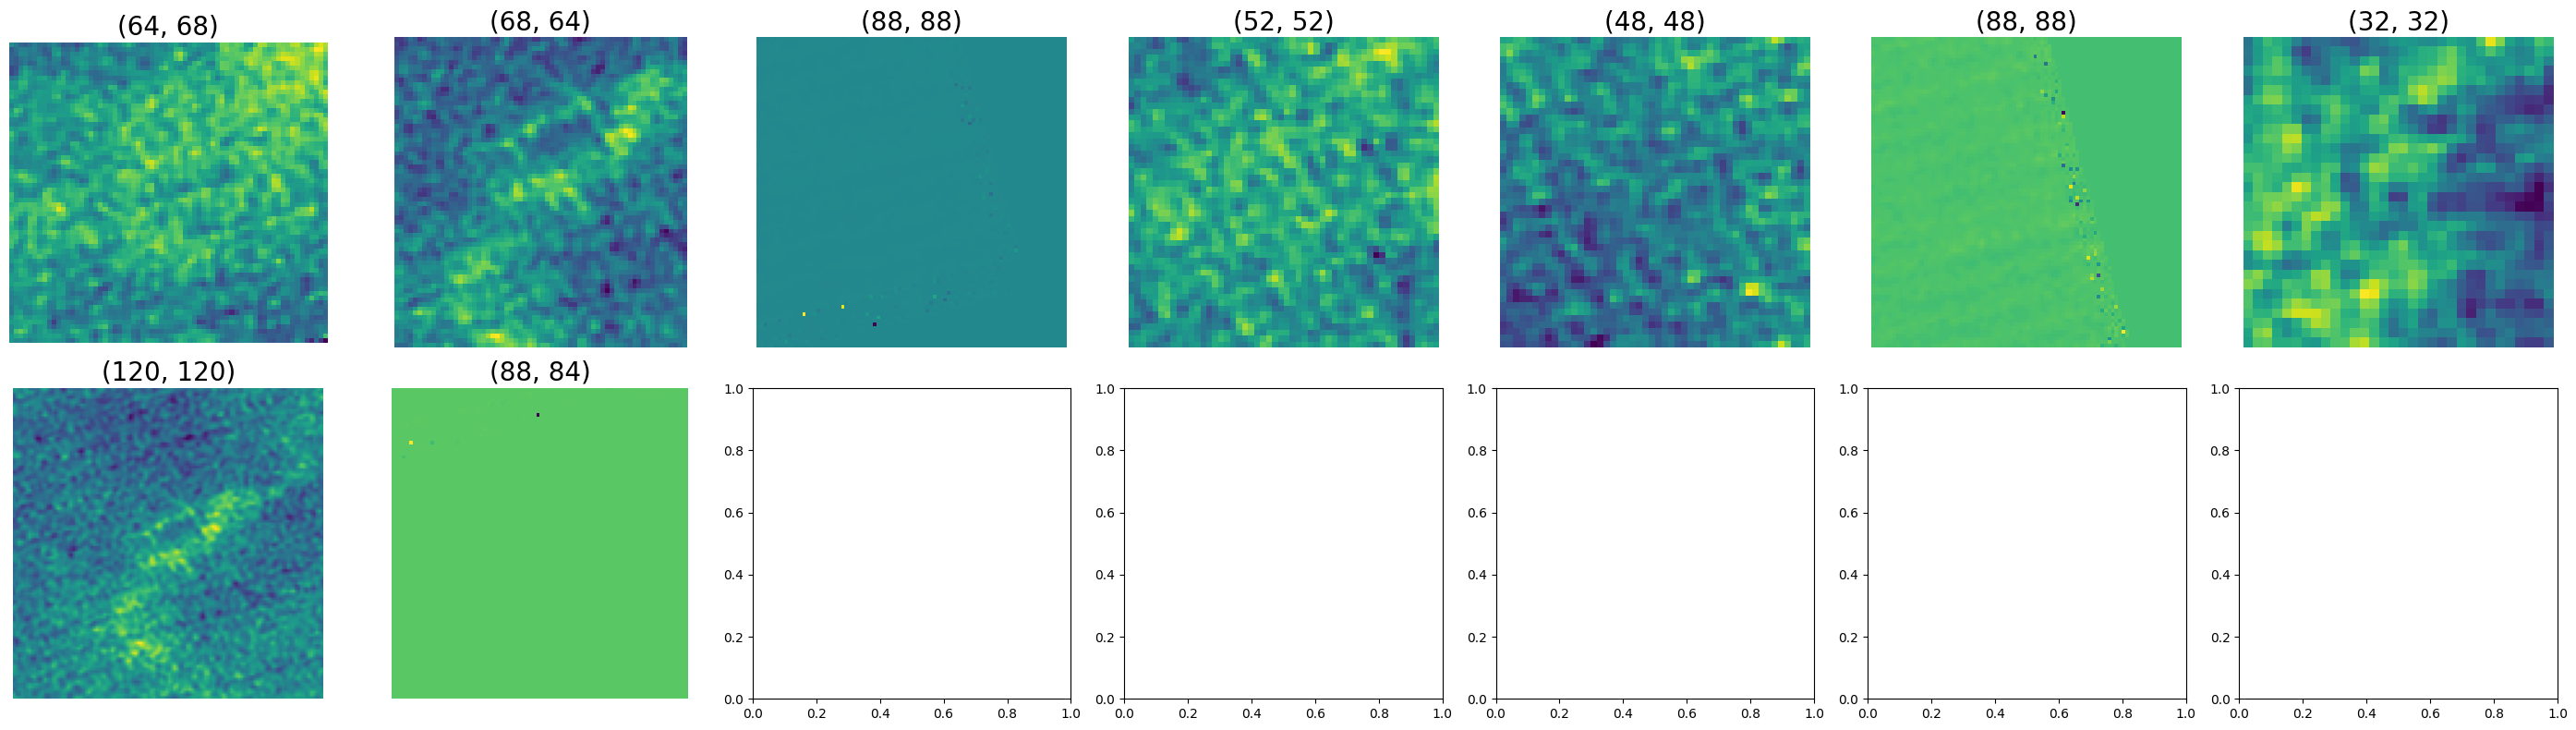

In [13]:
# Validation Data 確認

rows = len(validation_region_list) // 7 + 1

fig, axes = plt.subplots(rows, 7, figsize=(4*7, 4*rows))
axes = axes.flatten()  # 3x10の軸を1次元配列に変換

for n in range(len(validation_region_list)):  # 30個の画像を配置
    data = validation_region_list[n][1]
    integ_data = np.nansum(data, axis=0)
    
    axes[n].imshow(integ_data)
    axes[n].axis("off")
    axes[n].set_title((validation_region_list[n][1].shape[1], validation_region_list[n][1].shape[2]), fontsize=20)

plt.tight_layout()
# plt.savefig("bubbles_zeroing_integ_shape_3.png")
plt.show()

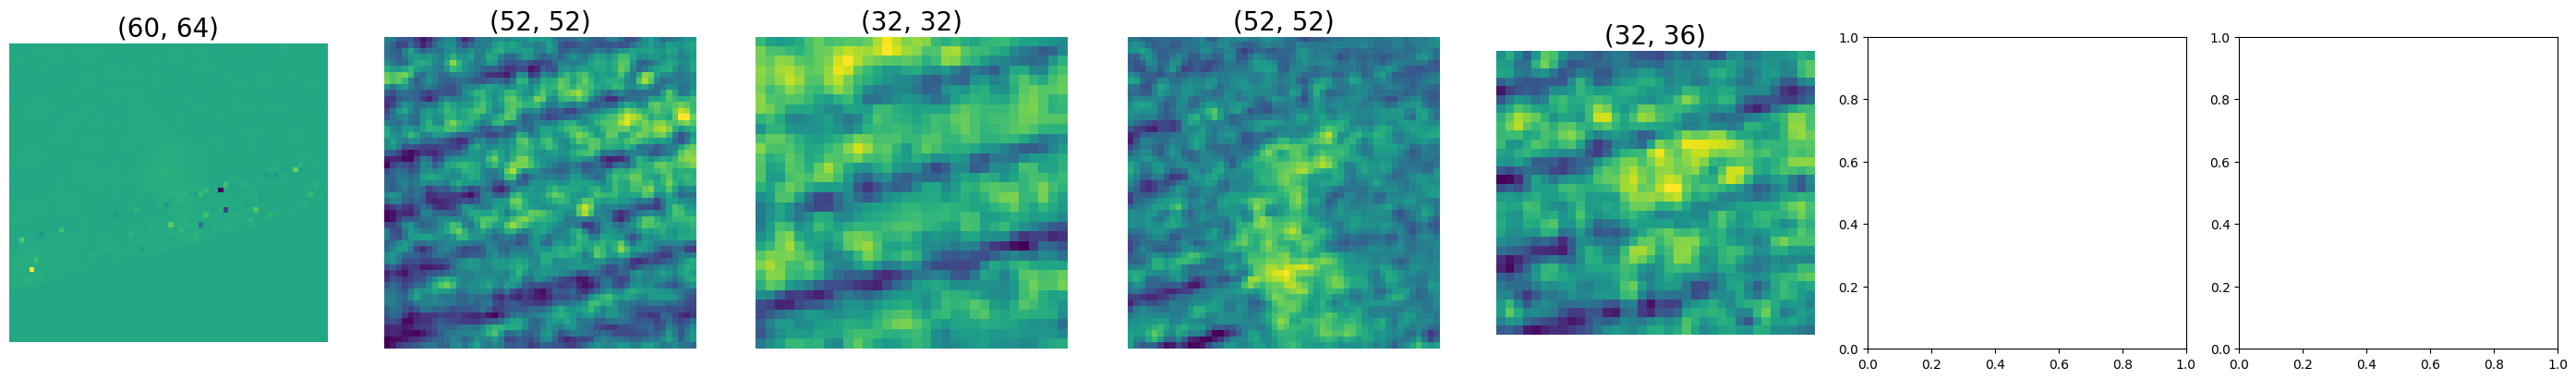

In [14]:
# Test Data 確認

rows = len(test_region_list) // 7 + 1

fig, axes = plt.subplots(rows, 7, figsize=(4*7, 4*rows))
axes = axes.flatten()  # 3x10の軸を1次元配列に変換

for n in range(len(test_region_list)):  # 30個の画像を配置
    data = test_region_list[n][1]
    integ_data = np.nansum(data, axis=0)
    
    axes[n].imshow(integ_data)
    axes[n].axis("off")
    axes[n].set_title((test_region_list[n][1].shape[1], test_region_list[n][1].shape[2]), fontsize=20)

plt.tight_layout()
# plt.savefig("bubbles_zeroing_integ_shape_3.png")
plt.show()

In [15]:
training_remove_list = [0, 3, 6, 7, 11, 13]
filtered_training_region_list = [data for i, data in enumerate(training_region_list) if i not in training_remove_list]

print("training bubble: ", len(filtered_training_region_list))

training bubble:  21


In [16]:
validation_remove_list = [2, 5, 8]
filtered_validation_region_list = [data for i, data in enumerate(validation_region_list) if i not in validation_remove_list]

print("validation bubble: ", len(filtered_validation_region_list))

validation bubble:  6


In [17]:
test_remove_list = [0]
filtered_test_region_list = [data for i, data in enumerate(test_region_list) if i not in test_remove_list]

print("test bubble: ", len(filtered_test_region_list))

test bubble:  4


In [18]:
all_map = raw_d.copy()

In [19]:
import itertools

vals = [-0.25, 0, 0.25]
combinations = [list(x) for x in itertools.product(vals, repeat=2)]
print(combinations)

[[-0.25, -0.25], [-0.25, 0], [-0.25, 0.25], [0, -0.25], [0, 0], [0, 0.25], [0.25, -0.25], [0.25, 0], [0.25, 0.25]]


In [20]:
slide_trainig_region = []
for pdu in filtered_training_region_list:
    pdu = pdu[0]
    x_min, x_max, y_min, y_max = pdu[0], pdu[1], pdu[2], pdu[3]
    diff_x = x_max - x_min
    diff_y = y_max - y_min

    for slide_val_x, slide_val_y in combinations:
        x_min_s = int(x_min + diff_x*slide_val_x)
        x_max_s = int(x_max + diff_x*slide_val_x)
        y_min_s = int(y_min + diff_y*slide_val_y)
        y_max_s = int(y_max + diff_y*slide_val_y)

        region = all_map[:, y_min_s:y_max_s, x_min_s:x_max_s].copy()
        slide_trainig_region.append(region)

print(len(slide_trainig_region))

189


In [21]:
filtered_validation_list = []
for pdu in filtered_validation_region_list:
    pdu = pdu[0]
    x_min, x_max, y_min, y_max = pdu[0], pdu[1], pdu[2], pdu[3]
    diff_x = x_max - x_min
    diff_y = y_max - y_min

    for slide_val_x, slide_val_y in combinations:
        x_min_s = int(x_min + diff_x*slide_val_x)
        x_max_s = int(x_max + diff_x*slide_val_x)
        y_min_s = int(y_min + diff_y*slide_val_y)
        y_max_s = int(y_max + diff_y*slide_val_y)

        region = all_map[:, y_min_s:y_max_s, x_min_s:x_max_s].copy()
        filtered_validation_list.append(region)

print(len(filtered_validation_list))

54


In [22]:
# filtered_validation_list = [data[1] for data in filtered_validation_region_list]
filtered_test_list = [data[1] for data in filtered_test_region_list]

print(len(filtered_validation_list))
print(len(filtered_test_list))

54
4


In [23]:
processed_training_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=slide_trainig_region,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )

processed_validation_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=filtered_validation_list,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )

processed_test_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=filtered_test_list,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [24]:
max_thresh = maximum_value_determination(
                                         mode=maximum_mode, 
                                         data=raw_d, 
                                         vsmooth=vsmooth, 
                                         sch_rms=sch_rms, 
                                         ech_rms=ech_rms, 
                                         sch_ii=sch_ii, 
                                         ech_ii=ech_ii, 
                                         sigma=sigma, 
                                         thresh=thresh, 
                                         integrate_layer_num=integrate_layer_num, 
                                         percentile=percentile
                                        )

======== maximum determination ========
-------- making v_convolution data --------
-------- masking data --------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-------- integrating and xy_convolution --------
percentile value is 282.12


In [29]:
conv_resize_training_list = []
for _data in tqdm(processed_training_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_training_list.append(_data)

conv_resize_training_list = normalization_thresh(conv_resize_training_list, max_thresh)


conv_resize_validation_list = []
for _data in tqdm(processed_validation_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_validation_list.append(_data)

conv_resize_validation_list = normalization_thresh(conv_resize_validation_list, max_thresh)


conv_resize_test_list = []
for _data in tqdm(processed_test_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_test_list.append(_data)

conv_resize_test_list = normalization_thresh(conv_resize_test_list, max_thresh)

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

# バブルデータ確認

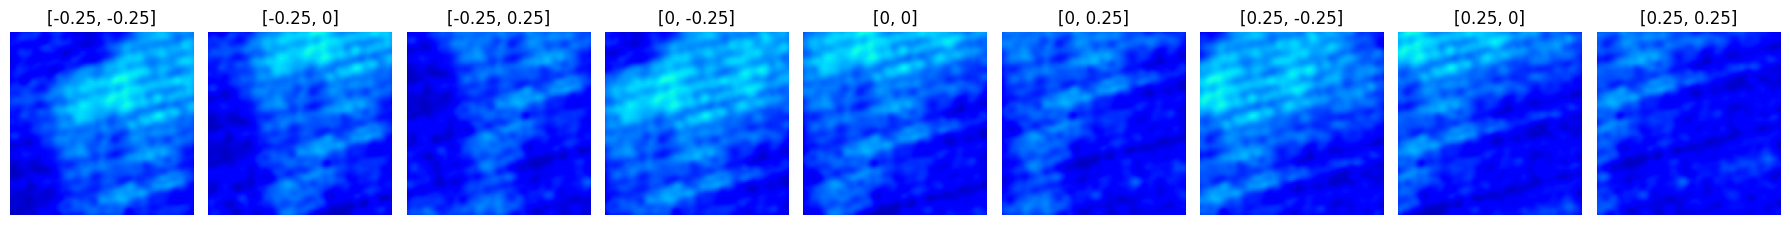

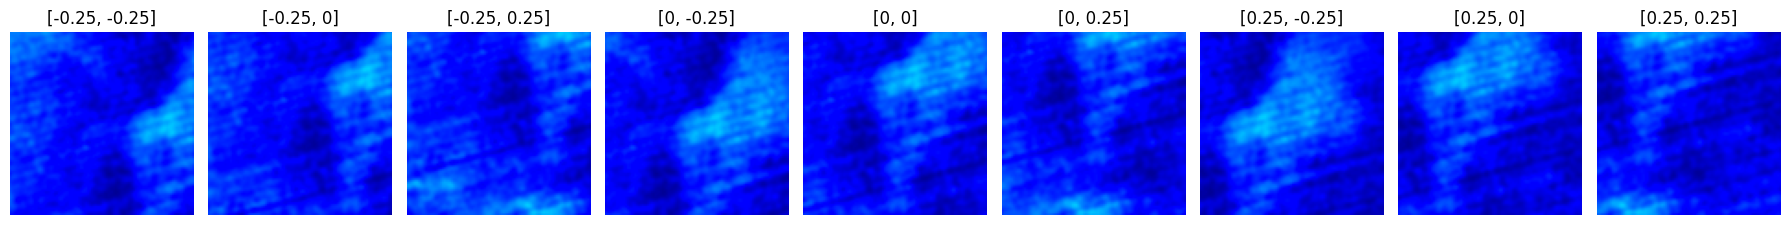

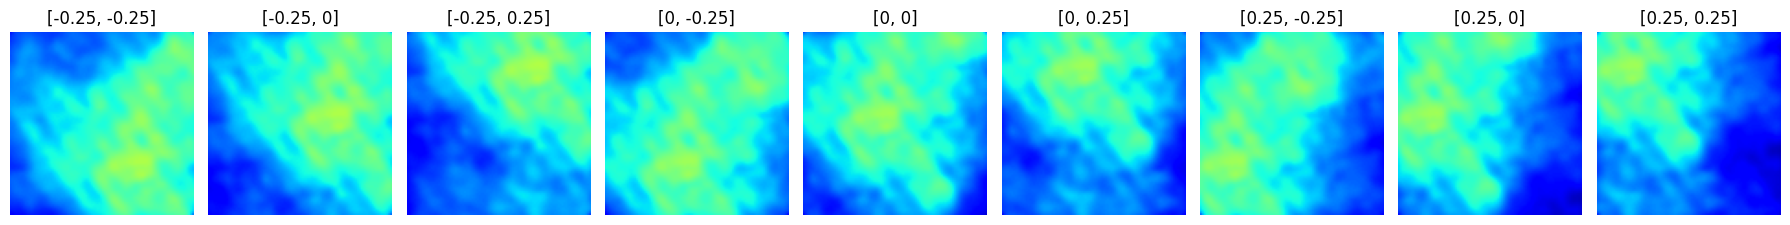

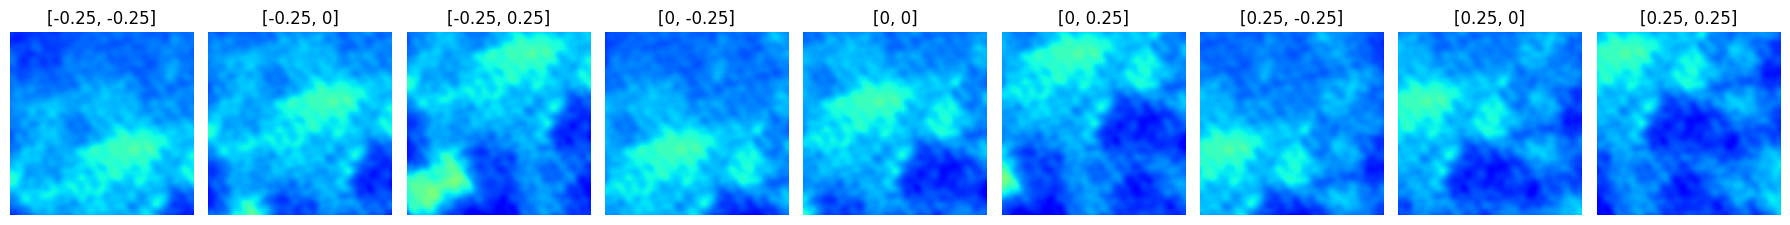

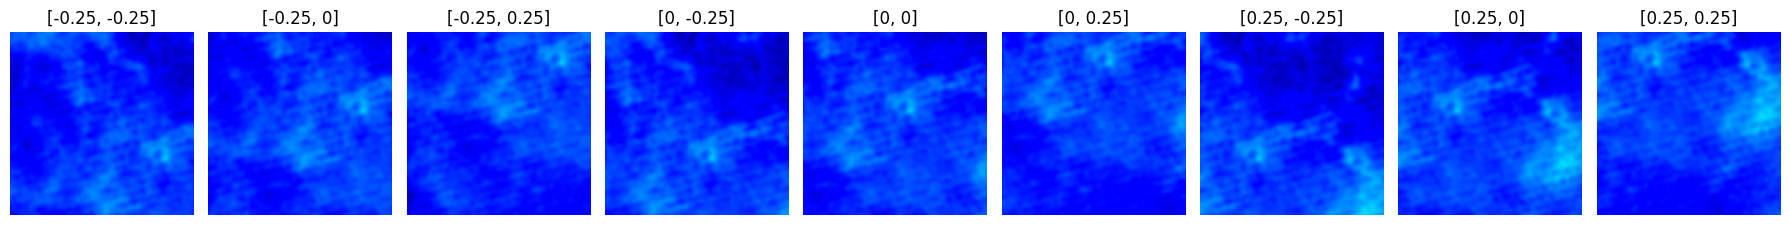

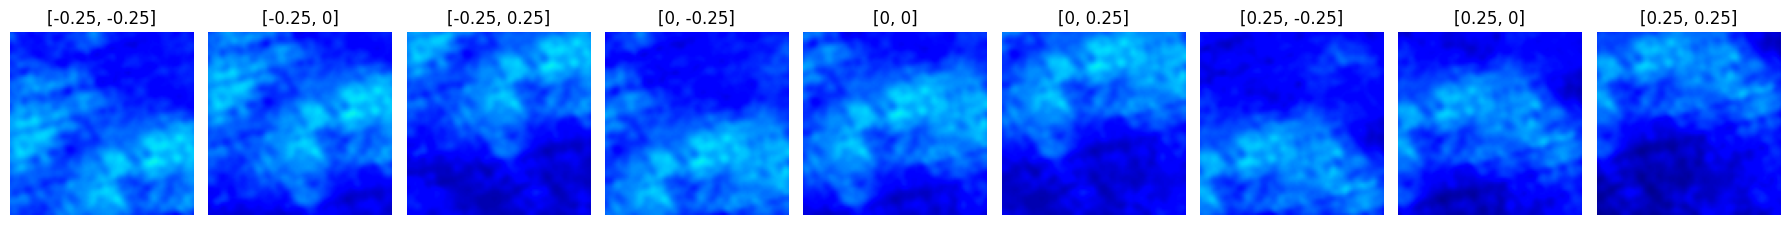

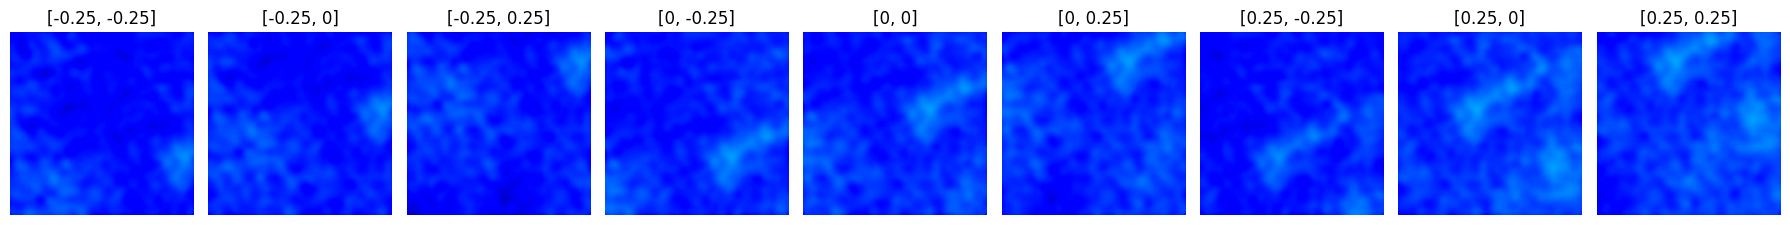

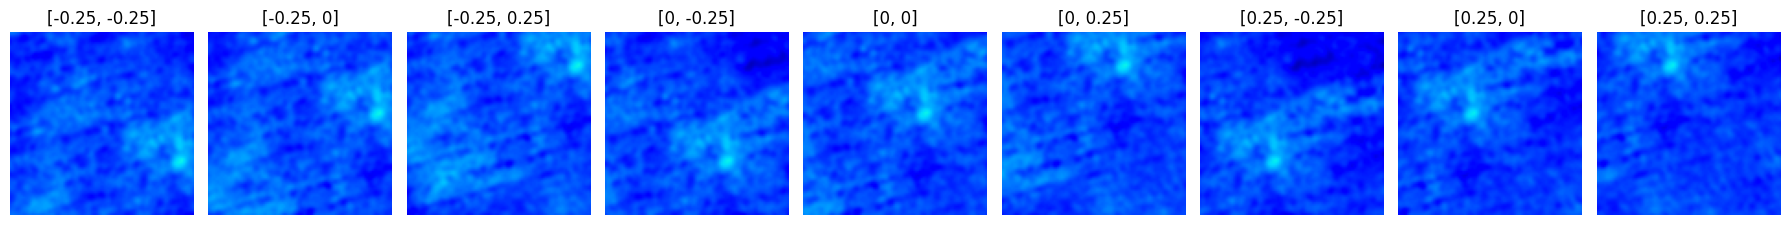

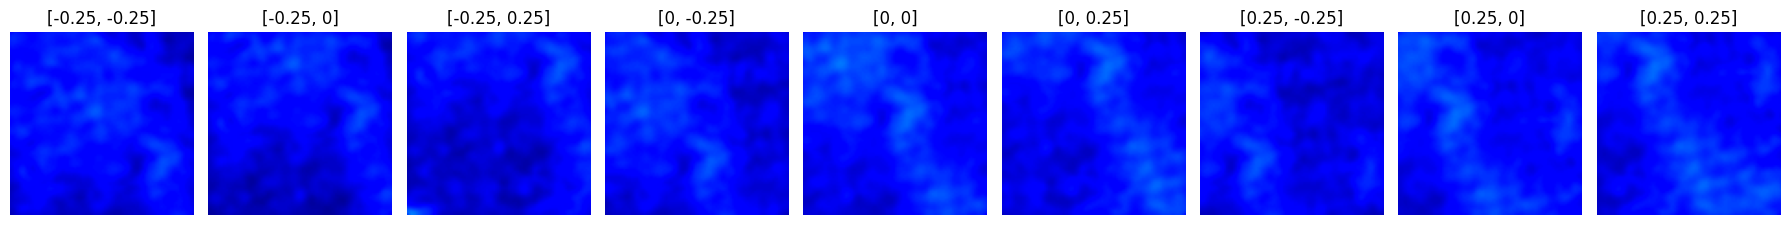

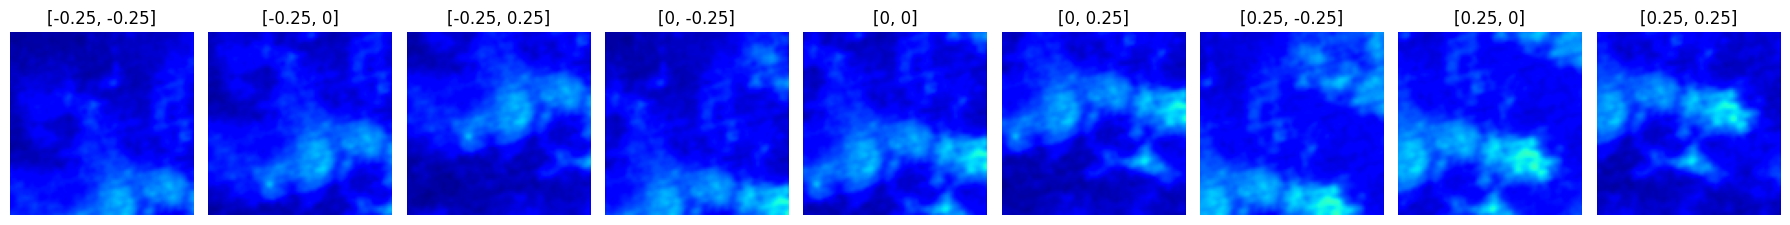

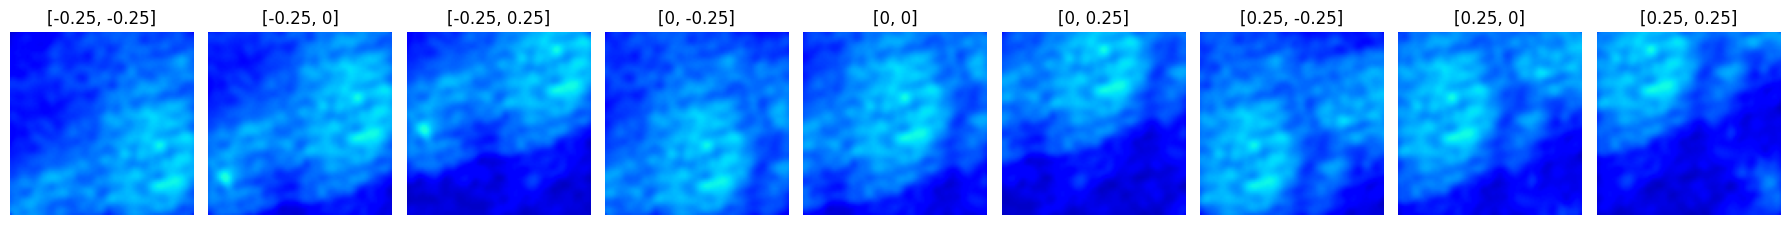

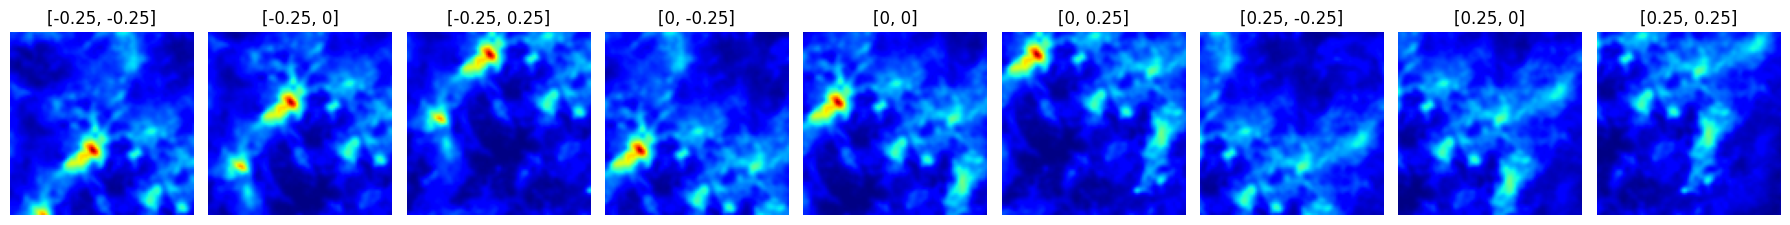

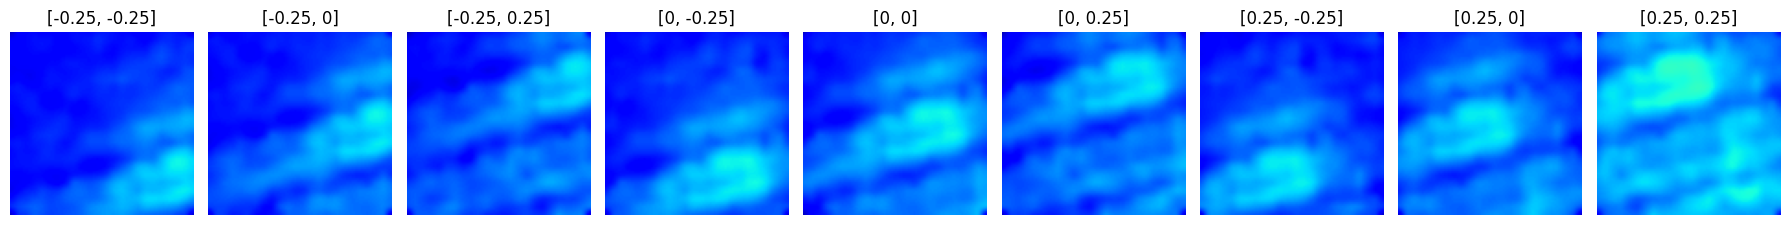

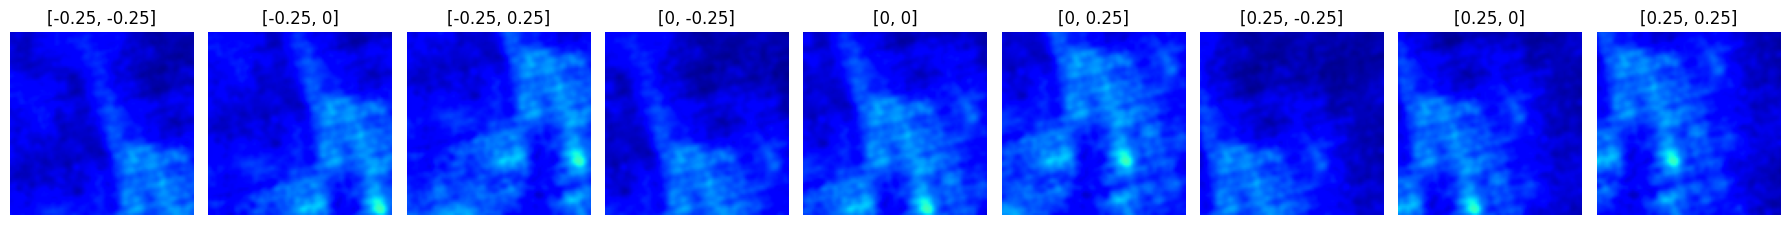

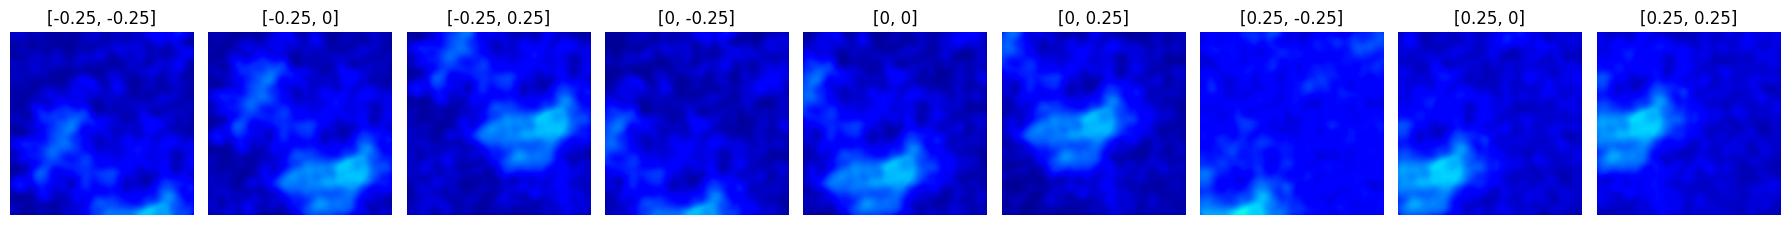

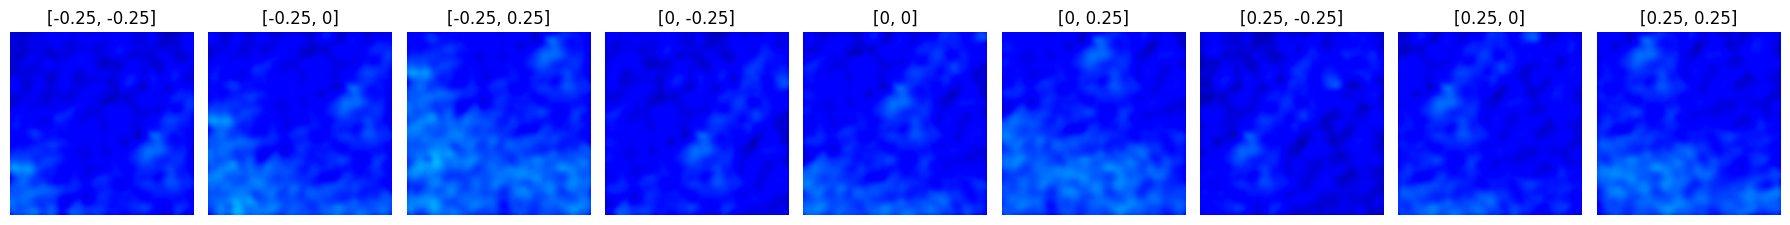

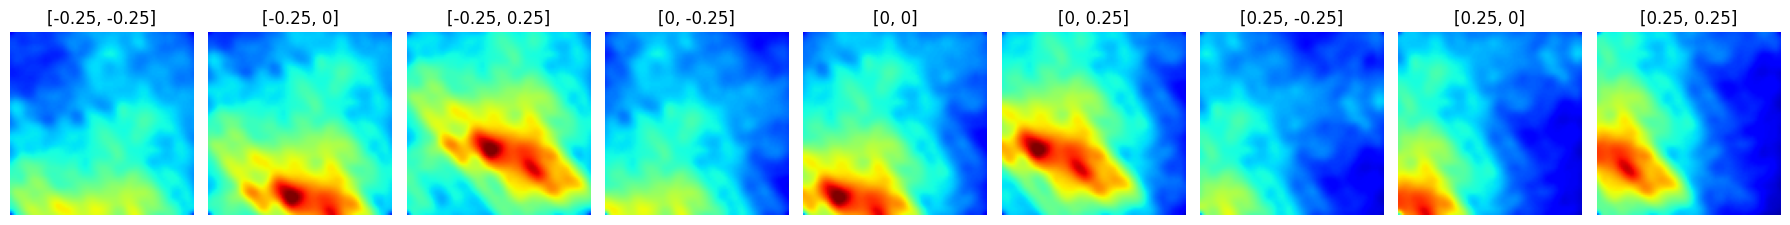

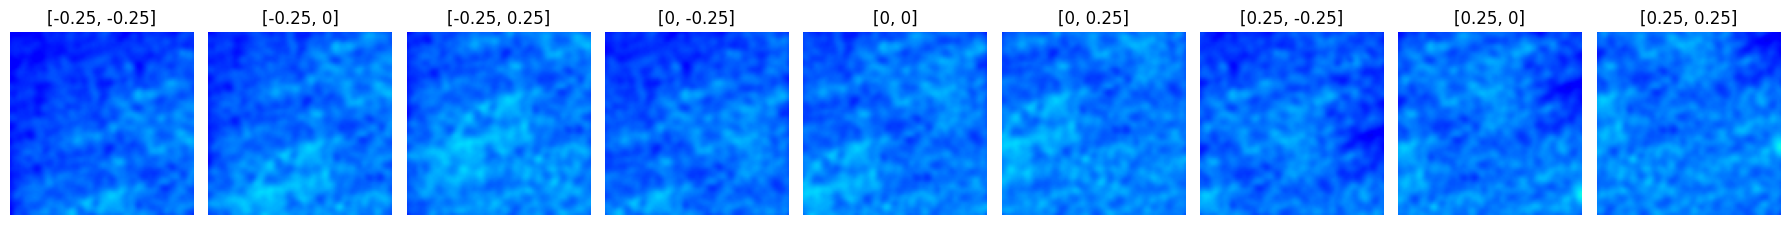

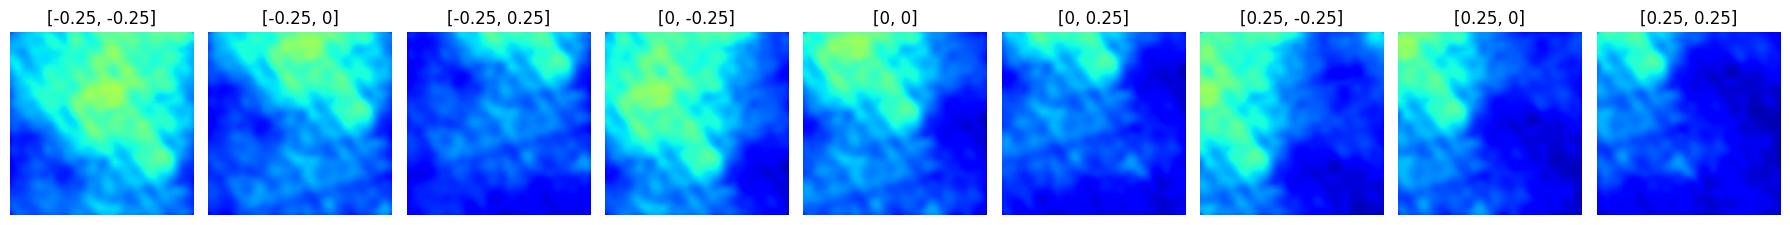

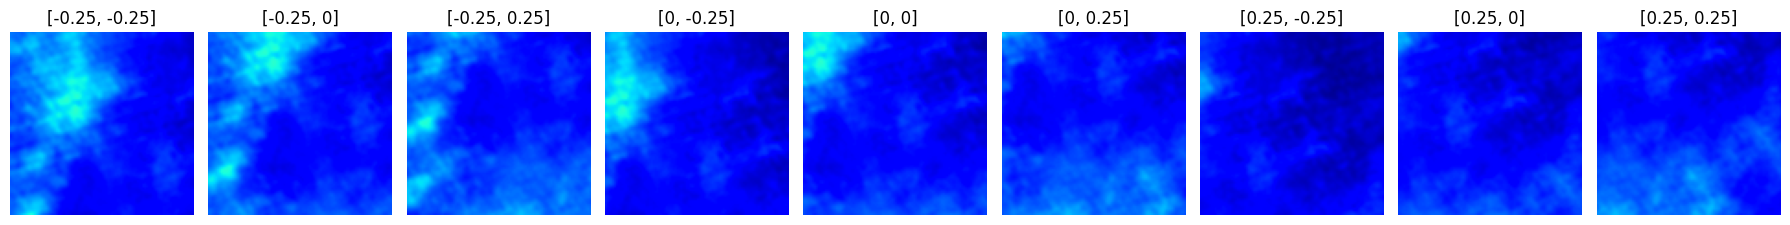

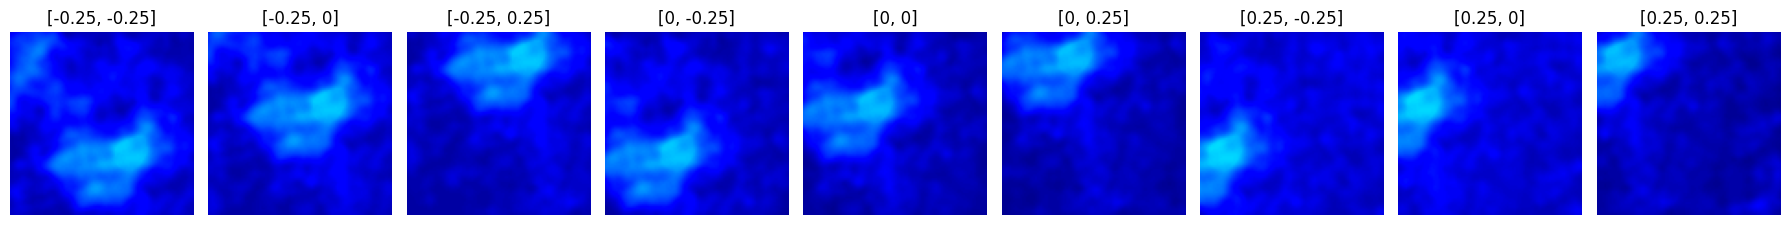

In [30]:
# Trainig バブル
COLS = 9
rows = (len(conv_resize_training_list) + COLS - 1) // COLS
data_index = 0

for line in range(rows):
    fig, axes = plt.subplots(1, COLS, figsize=(2 * COLS, 3))
    axes_flat = axes.flatten()
    
    for k in range(COLS):
        if data_index < len(conv_resize_training_list):
            data_num = data_index
                        
            ax = axes_flat[k]
            data = conv_resize_training_list[data_num]
            
            ax.imshow(np.sum(data, axis=0), cmap="jet", vmin=0, vmax=6) 
            ax.set_title(f"{combinations[k]}")
            ax.axis("off")
            
            data_index += 1
        else:
            axes_flat[k].axis("off")

    plt.tight_layout()
    # plt.savefig(f"Training_Bubble_No.{line}.png")
    plt.show()

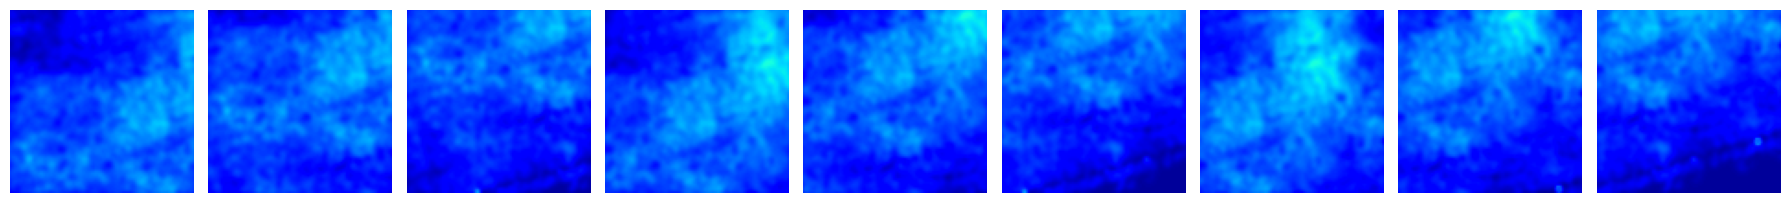

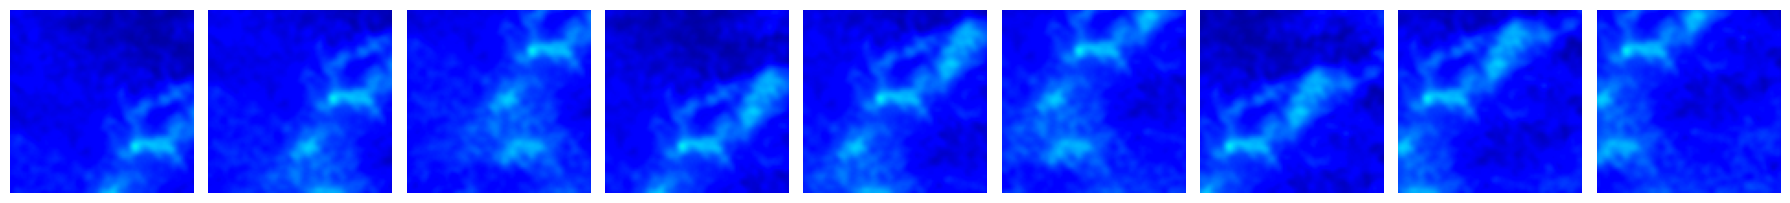

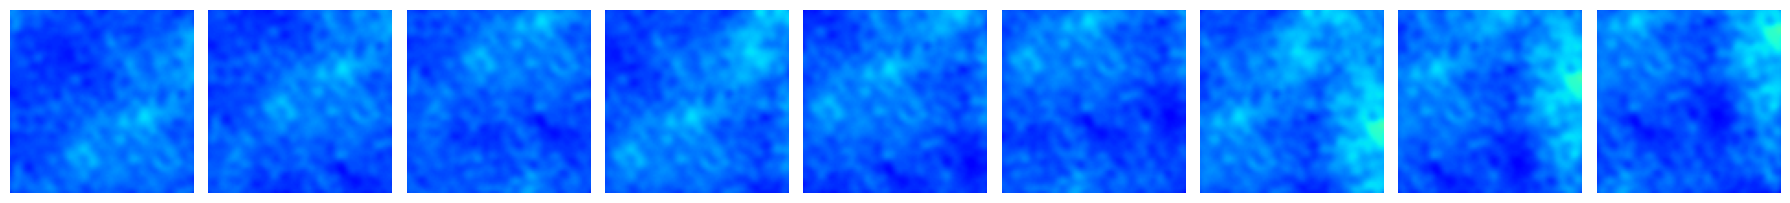

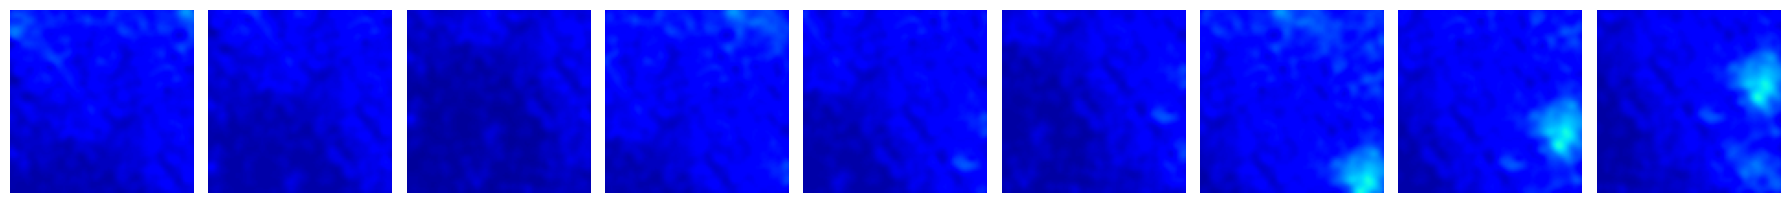

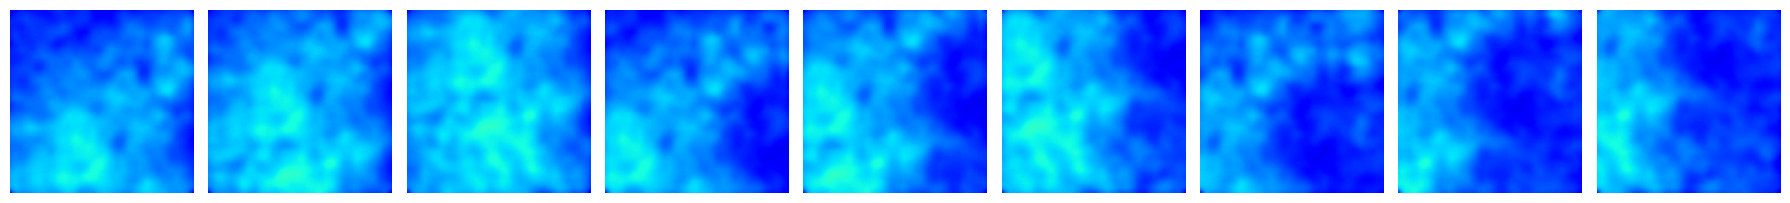

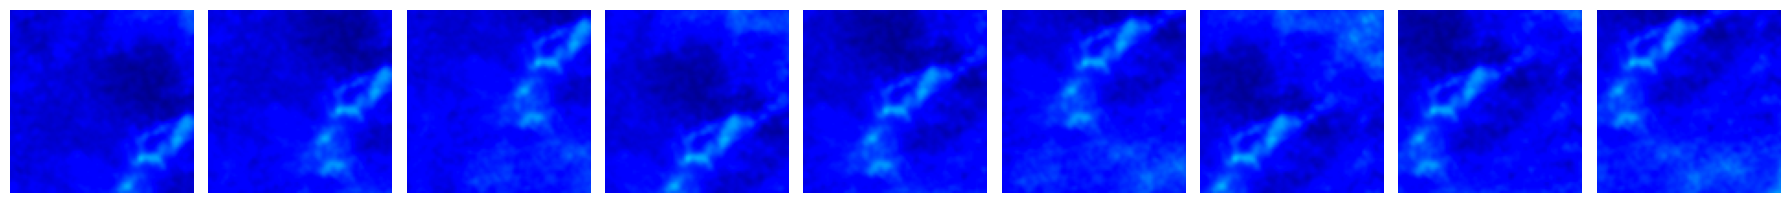

In [31]:
# Validation バブル
COLS = 9
rows = (len(conv_resize_validation_list) + COLS - 1) // COLS
data_index = 0

for line in range(rows):
    fig, axes = plt.subplots(1, COLS, figsize=(2 * COLS, 3))
    axes_flat = axes.flatten()
    
    for k in range(COLS):
        if data_index < len(conv_resize_validation_list):
            data_num = data_index
                        
            ax = axes_flat[k]
            data = conv_resize_validation_list[data_num]
            
            ax.imshow(np.sum(data, axis=0), cmap="jet", vmin=0, vmax=6) 
            # ax.set_title(f"{combinations[k]}")
            ax.axis("off")
            
            data_index += 1
        else:
            axes_flat[k].axis("off")

    plt.tight_layout()
    # plt.savefig(f"Validation_Bubble.png")
    plt.show()

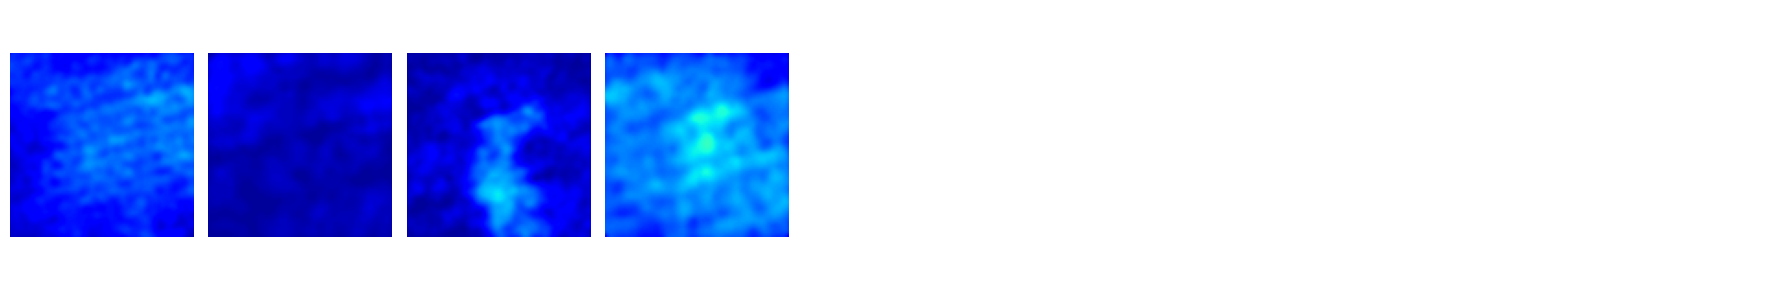

In [32]:
# Test バブル
COLS = 9
rows = (len(conv_resize_test_list) + COLS - 1) // COLS
data_index = 0

for line in range(rows):
    fig, axes = plt.subplots(1, COLS, figsize=(2 * COLS, 3))
    axes_flat = axes.flatten()
    
    for k in range(COLS):
        if data_index < len(conv_resize_test_list):
            data_num = data_index
                        
            ax = axes_flat[k]
            data = conv_resize_test_list[data_num]
            
            ax.imshow(np.sum(data, axis=0), cmap="jet", vmin=0, vmax=6) 
            # ax.set_title(f"{combinations[k]}")
            ax.axis("off")
            
            data_index += 1
        else:
            axes_flat[k].axis("off")

    plt.tight_layout()
    # plt.savefig(f"Test_Bubble.png")
    plt.show()

In [30]:
np.save("./processed_data/split_area/training_data/training_bubble", conv_resize_training_list)
np.save("./processed_data/split_area/validation_data/validation_cheating_bubble", conv_resize_validation_list)
np.save("./processed_data/split_area/test_data/test_bubble", conv_resize_test_list)

In [33]:
bubble_all = conv_resize_training_list + conv_resize_validation_list + conv_resize_test_list
np.save("./processed_data/all_velocity/all_velocity_bubble", bubble_all)